## Projekt 2 - warsztaty badawcze 2020

### Anna Kozioł, Andżelika Zalewska 

###  Wstepne przetworzenie danych 

In [2]:
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from collections import Counter
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import seaborn as sns


from copy import deepcopy
from skfuzzy import control as ctrl

In [ ]:

df = pd.read_csv('data_BD_2020_04_03_cleaned.csv', decimal=",").drop("Unnamed: 0", 1)
df = df.fillna(0)
df["date_day"] = pd.to_datetime(df["date"])
df = df.rename(columns={"hamd":"hamd_sum","yms":"yms_sum"})
for column in df.columns[3:-1]:
    df[column] = pd.to_numeric(df.loc[:,column])
feature_list = ['context_no_day_incoming_calls', 'context_avg_day_duration_incoming',
       'context_stddev_duration_incoming', 'context_no_day_outgoing_calls',
       'context_avg_day_duration_outgoing', 'context_stddev_duration_outgoing',
       'context_no_nottakencalls', 'context_no_sms', 'context_avg_len_sms',
       'context_no_calls', 'context_prc_nottakencalls',
       'context_prc_out_calls', 'context_avg_duration_calls',
       'self_avg_sleep_time', 'self_avg_comment_len_sleep', 'self_avg_feeling',
       'self_avg_comment_len_mood', 'self_ismixed',
       'context_stddev_duration_calls', 'context_no_all_calls',
       'context_distance_nr', 'context_stepnbr']

df1 = df[feature_list+['hamd_sum','yms_sum']]
for i in df1.columns:
    df1[i]=(df1[i]-df1[i].min())/(df1[i].max()-df1[i].min())
df2 = pd.concat([df["patient_id"], df1], axis=1)
df = df2
df.to_csv('dane_przerobione.csv')

### Zdefiniowanie i ilistracja zmiennych lingwistycznych

Poniżej przykładowa ilustracja dla zmiennej "context_no_day_incoming_calls"

In [10]:
def zmienna_lingwistyczna(zmienna):
    d = df[zmienna]
    max_for_universe = np.max(d)
    min_for_universe = np.min(d)
    
    kwantyl_0 = d.quantile(0)
    kwantyl_025 = d.quantile(0.25)
    kwantyl_03 = d.quantile(0.3)
    kwantyl_05 = d.quantile(0.5)
    kwantyl_07 = d.quantile(0.7)
    kwantyl_075 = d.quantile(0.75)
    kwantyl_1 = d.quantile(1)
    
    universe = np.arange(min_for_universe, max_for_universe + 0.1, 0.1)

    reg = ctrl.Consequent(universe, "hh")
    low = fuzz.trapmf(reg.universe, [kwantyl_0, kwantyl_0, kwantyl_03, kwantyl_05])
    medium = fuzz.trapmf(reg.universe, [kwantyl_025, kwantyl_03, kwantyl_07, kwantyl_075])
    high = fuzz.trapmf(reg.universe, [kwantyl_05, kwantyl_07, kwantyl_1, kwantyl_1])

    plt.plot(universe, low)
    plt.plot(universe, medium)
    plt.plot(universe, high)
    plt.title('Zmienne lingwistyczne dla zmiennej '+zmienna)

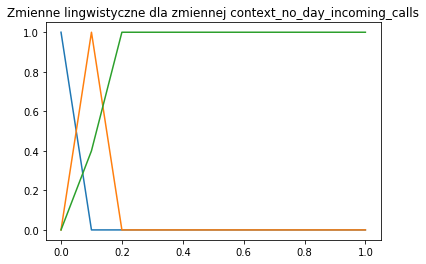

In [11]:
zmienna_lingwistyczna('context_no_day_incoming_calls')

### 3. Funkcja  generate_short_linguistic_summaries dla LS1

In [27]:
def generate_short_linguistic_summaries(nazwa_parametru,ramka, podmiot_podsumowania = None,
                                        klasyfikator_pacj = klasyfikator2, klasyfikator_wsk = klasyfikator):
    if podmiot_podsumowania == None:
        df = ramka.loc[:,nazwa_parametru].dropna()
        length = len(df.index)
    else:
        df = ramka.loc[ramka.patient_id == podmiot_podsumowania, nazwa_parametru].dropna()
        length = len(df.index)
    wartosci = ["low","medium","high"]
    wartosci2 = ["minority","half","majority"]
    powielenia = [wartosci[np.argmax(klasyfikator_wsk(i))] for i in df.values]
    zdania = []
    powielenia_licznosci = dict(Counter(powielenia))
    odsetki = {key: value_length/length for key, value_length in powielenia_licznosci.items()}
    wynik = {key : wartosci2[np.argmax(klasyfikator_pacj(value))] for key,value in odsetki.items()}
    [zdania.append("For the " + value + " of patients " + nazwa_parametru + " is " + key +".") for key, value in wynik.items()]      
    final_df = pd.DataFrame(columns = ["sentence","degree_of_truth", "degree_of_support"])    
    for sentence in zdania:
        d = degree_of_truth(sentence,ramka,norm="min")
        e = degree_of_support(sentence,ramka,norm="min")
        final_df = final_df.append({"sentence":sentence,"degree_of_truth":d, "degree_of_support":e},
                                  ignore_index = True)    
    
    return final_df

### Funkcja generate_extended_linguistic_summaries dla LS2

In [26]:
def generate_extended_linguistic_summaries(nazwa_parametru,data, podmiot_podsumowania = None,tnorm="min",
                                          kwantyfikator_pacj = klasyfikator2, kwantyfikator_wsk = klasyfikator,
                                          kwalifikator = klasyfikator ):
    if podmiot_podsumowania==None:
        df = data.loc[:,nazwa_parametru].dropna()
        length = len(df.index)
    else:
        df = data.loc[data.patient_id == podmiot_podsumowania, nazwa_parametru].dropna()
        length = len(df.index)
    wartosci = ["low","medium","high"]
    wartosci2 = ["minority","half","majority"]
    values = [wartosci[np.argmax(kwantyfikator_wsk(i))] for i in df.values]
    zdania = [] 
    df2 = data.loc[df.index,[nazwa_parametru,"hamd_sum","yms_sum"]].reset_index(drop=True)
    values_depression =[wartosci[np.argmax(kwalifikator(i))] for i in df2["hamd_sum"].values]
    depression = {i : [k for k,l in enumerate(values_depression) if l == i] for i in wartosci}
    values_mania = [wartosci[np.argmax(kwalifikator(i))] for i in df2["yms_sum"].values]
    mania = {i : [k for k, l in enumerate(values_mania) if l == i] for i in wartosci}
    wynik = {"depression":{}, "mania" : {}}
    for key, indexes in depression.items():
        wynik["depression"][key] = dict(Counter([values[i] for i in indexes]))
        leng= sum(list(wynik["depression"][key].values()))
        wynik["depression"][key] = {key: wartosci2[np.argmax(kwantyfikator_pacj(value/leng))] for key, value in wynik["depression"][key].items()}
    for key, indexes in mania.items():
        wynik["mania"][key] = dict(Counter([values[i] for i in indexes]))
        leng= sum(list(wynik["mania"][key].values()))
        wynik["mania"][key] = {key: wartosci2[np.argmax(kwantyfikator_pacj(value/leng))] for key, value in wynik["mania"][key].items()}
    for key,value in wynik.items():
        for key2, value2 in value.items():            
            [zdania.append(("For the {} of people with {} level of {} symptoms, {} is {}.")\
                           .format(value3,key2,key,nazwa_parametru,key3)) for key3, value3 in value2.items()]
            
    final_df = pd.DataFrame(columns = ["sentence","degree_of_truth", "degree_of_support", "degree_of_focus"])    
    for sentence in zdania:
        d = degree_of_truth(sentence,data,norm=tnorm,ls2=True)
        e = degree_of_support(sentence,data,norm=tnorm,ls2=True)
        f = degree_of_focus(sentence,data,norm=tnorm,ls2=True)
        final_df = final_df.append({"sentence":sentence,"degree_of_truth":d, "degree_of_support":e, "degree_of_focus":f},
                              ignore_index = True)
                               
                
    return final_df

### Utworzenie  wszystkich możliwych podsumowań lingwistycznych dla 10 wybranych zmiennych i zapisanie do pliku 100 najbardziej prawdziwych 

In [28]:
wybrane_parametry = ['context_no_day_incoming_calls', 'context_avg_day_duration_incoming',
       'context_stddev_duration_incoming', 'context_no_day_outgoing_calls',
       'context_avg_day_duration_outgoing', 'context_stddev_duration_outgoing',
       'context_no_nottakencalls', 'context_no_sms', 'context_avg_len_sms',
       'context_no_calls']

In [34]:
ramka = pd.DataFrame()
for zmienna in wybrane_parametry:
    zdania = generate_short_linguistic_summaries(zmienna,df, podmiot_podsumowania = None,
                                        klasyfikator_pacj = klasyfikator2, klasyfikator_wsk = klasyfikator)
    ramka = pd.concat([ramka, zdania])
    
ramka2 = pd.DataFrame()

for zmienna in wybrane_parametry:
    zdania = generate_extended_linguistic_summaries(zmienna,df, podmiot_podsumowania = None,tnorm="min",
                                          kwantyfikator_pacj = klasyfikator2, kwantyfikator_wsk = klasyfikator,
                                          kwalifikator = klasyfikator )
    ramka2 = pd.concat([ramka2, zdania])

In [35]:
ramka2=ramka2[['sentence', 'degree_of_truth', 'degree_of_support']]
ramka_ostateczna = pd.concat([ramka,ramka2])
zdania_do_csv = ramka_ostateczna.sort_values('degree_of_truth', ascending = False).head(100)['sentence']
zdania_do_csv.to_csv("selected_summaries.csv", index=False)

### . Funkcje pomocnicze

In [3]:
def klasyfikator(x):
    universe = np.arange(0,1.01,0.01)
    low = fuzz.trimf(universe,[0,0,0.5])
    medium = fuzz.trimf(universe,[0,0.5,1])
    high = fuzz.trimf(universe,[0.51,1,1])
    return [fuzz.interp_membership(universe,i,x) for i in [low,medium,high]] 

In [4]:
def klasyfikator2(x):
    universe = np.arange(0,1.01,0.01)
    minority = fuzz.trimf(universe,[0,0,0.5])
    half = fuzz.trimf(universe,[0.45,0.5,0.55])
    majority = fuzz.trimf(universe,[0.51,1,1])
    return [fuzz.interp_membership(universe,i,x) for i in [minority,half,majority]] 

In [5]:
def norma(x1,x2,how="min"):
    if how == "min":
        return min(x1,x2)
    elif how == "luk":
        return max(0,x1+x2-1)

In [6]:
def parse_sentence(sentence, ls2=False):
    sentence = sentence.split(" ")
    if ls2:
        result ={"quantity11":sentence[6],"state":sentence[9],"quantity2":sentence[2], "feature":sentence[11],
                "quantity12":sentence[13][:-1]}
    else:
        result = {"quantity2": sentence[2], "feature":sentence[5],"quantity11":sentence[7][:-1]}
    return result

In [7]:
def degree_of_truth(sentence,data,norm="min",ls2=False):
    res = parse_sentence(sentence,ls2=ls2)
    quantity = ["low","medium","high"]
    quantity2 = ["minority","half","majority"]
    obs = data[res["feature"]]
    if ls2:
        translate = {"mania":"yms_sum","depression":"hamd_sum"}
        state = data[translate[res["state"]]]
        z = np.sum([norma(klasyfikator(o)[quantity.index(res["quantity11"])], 
                         klasyfikator(p)[quantity.index(res["quantity12"])], how =norm) for o, p in zip(state,obs)])
        z2 = np.sum([klasyfikator(o)[quantity.index(res["quantity11"])] for o in state])
        q = klasyfikator(z/z2)[quantity2.index(res["quantity2"])]
    else:
        q = klasyfikator(np.mean([klasyfikator2(o)[quantity.index(res["quantity11"])] for o in obs]))\
            [quantity2.index(res["quantity2"])]
    return q

In [8]:
def degree_of_support(sentence,data,norm="min",ls2=False):
    res = parse_sentence(sentence,ls2=ls2)
    quantity = ["low","medium","high"]
    quantity2 = ["minority","half","majority"]
    obs = data[res["feature"]]
    if ls2:
        translate = {"mania":"yms_sum","depression":"hamd_sum"}
        state = data[translate[res["state"]]]
        q1 = [klasyfikator2(o)[quantity.index(res["quantity11"])] for o in state]
        q2 = [klasyfikator2(p)[quantity.index(res["quantity12"])] for p in obs]
        for n, i in enumerate(q1):
            if i > 0:
                q1[n] = 1.0
        for n, i in enumerate(q2):
            if i > 0:
                q2[n] = 1.0
        q = np.mean(norma(q1,q2,how = norm))
    else:
        q1 = [klasyfikator2(o)[quantity.index(res["quantity11"])] for o in obs]
        q = sum(i > 0 for i in q1)/len(q1)
    return q

In [33]:
def degree_of_focus(sentence,data,norm="min",ls2=False):
    res = parse_sentence(sentence,ls2=ls2)
    quantity = ["low","medium","high"]
    quantity2 = ["minority","half","majority"]
    obs = data[res["feature"]]
    if ls2:
        translate = {"mania":"yms_sum","depression":"hamd_sum"}
        state = data[translate[res["state"]]]
        q = np.mean([klasyfikator(o)[quantity.index(res["quantity11"])] for o in state])
    else:
        q = 'NaN'
    return q